In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 生成数据集

⽣成⼀个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是⼀个矩阵X ∈ R^1000×2。  
使⽤线性模型参数w = [2, −3.4]⊤、b = 4.2 和噪声项ϵ⽣成数据集及其标签：  
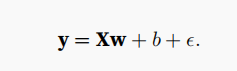  
ϵ可以视为模型预测和标签时的潜在观测误差。ϵ服从均值为0的正态分布。

In [4]:
def synthetic_data(w, b, num_examples): #@save
    """⽣成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
#features中的每⼀⾏都包含⼀个⼆维数据样本，labels中的每⼀⾏都包含⼀维标签值（⼀个标量）
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.6157, -1.4192]) 
label: tensor([10.2670])


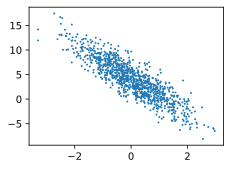

In [7]:
#可视化
#通过⽣成第⼆个特征features[:, 1]和labels的散点图，可以直观观察到两者之间的线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

# 读取数据集

定义⼀个data_iter函数，该函数接收批量⼤⼩、特征矩阵和标签向量作为输⼊，⽣成⼤⼩为batch_size的⼩批量。每个⼩批量包含⼀组特征和标签。

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [9]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4423, -1.2233],
        [ 1.2077,  2.0480],
        [ 0.1022,  1.3008],
        [ 0.8159, -0.9399],
        [ 0.1241,  0.6068],
        [ 0.8047, -0.0299],
        [-0.5473,  0.3208],
        [-0.7602, -0.6158],
        [ 0.6919, -1.0897],
        [-0.6418, -1.1164]]) 
 tensor([[ 9.2394],
        [-0.3332],
        [-0.0305],
        [ 9.0378],
        [ 2.3779],
        [ 5.9080],
        [ 2.0077],
        [ 4.7795],
        [ 9.2920],
        [ 6.7061]])


# 初始化模型参数